In [1]:
# 1.) Generate sequence of length k using Student model
# 2.) Evaluate drafted sequence using Teacher model
# 3.) Evaluate drafted sequence using Student model
# 4.) Calculate loss
# 5.) Backprop

In [38]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.utils import logging
import matplotlib.pyplot as plt
from datasets import load_dataset

logging.set_verbosity_error()

import torch
from torch.utils.data import DataLoader

In [3]:
student_model_id = "Qwen/Qwen2.5-0.5B-Instruct"
teacher_model_id = "Qwen/Qwen2.5-1.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(student_model_id)
pad_token_id = tokenizer.pad_token_id
eos_token_id = tokenizer.eos_token_id

student = AutoModelForCausalLM.from_pretrained(
    student_model_id,
    attn_implementation="flash_attention_2",
    torch_dtype=torch.float16,
    device_map="cuda:1",
)
student.config.pad_token_id = pad_token_id
student.config.eos_token_id = eos_token_id

teacher = AutoModelForCausalLM.from_pretrained(
    teacher_model_id,
    attn_implementation="flash_attention_2",
    torch_dtype=torch.float16,
    device_map="cuda:1",
).eval()
teacher.config.pad_token_id = pad_token_id
teacher.config.eos_token_id = eos_token_id

In [4]:
ds = load_dataset("abisee/cnn_dailymail", "3.0.0", split="train[:1%]")

In [ ]:
# ================
# Need to find a way to tokenize text that preserves the attention mask while also
# making a clear END to the user input. Currently, the models are just completing
# whatever the input text was if the tokenizer truncates.
# ================
def tokenize_function(examples, tokenizer, max_length):
    end_marker = ""
    end_ids = tokenizer(end_marker, add_special_tokens=False)["input_ids"]

    prompt = [
        {"role": "system", "content": "You are a concise, factual assistant."},
        {"role": "user", "content": "Summarize the following text."},
        {"role": "user", "content": examples["article"]},
    ]

    tokenized_prompt = tokenizer.apply_chat_template(
        prompt,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        # enable_thinking=False,
        padding="max_length",
        truncation=True,
        max_length=max_length - len(end_ids),
        return_tensors=None,
    )

    return {
        "input_ids": tokenized_prompt["input_ids"],
        "attention_mask": tokenized_prompt["attention_mask"],
    }


tokenized_dataset = ds.map(
    tokenize_function,
    fn_kwargs={"tokenizer": tokenizer, "max_length": 512},
    batched=False,
    remove_columns=ds.column_names,
)

# 2) Tell datasets to return torch tensors on indexing
tokenized_dataset = tokenized_dataset.with_format(
    type="torch",
    columns=["input_ids", "attention_mask"],
)

In [78]:
# Will use this for training loop
dl = DataLoader(tokenized_dataset, batch_size=10, shuffle=True, drop_last=True)

In [79]:
# 1. Generate sequence with length k from Student model
k = 64

# Sample per iteration
# torch.distributions.uniform.Uniform(0.75, 1.25).sample()

for batch in dl:
    with torch.no_grad():
        outputs = student.generate(
            input_ids=batch["input_ids"].to(student.device),
            attention_mask=batch["attention_mask"].to(student.device),
            max_new_tokens=k,
            do_sample=False,
            use_cache=True,
            return_dict_in_generate=False,
            output_scores=False,
        )
    break

In [ ]:
print(tokenizer.decode(outputs[0][: batch["input_ids"].shape[1]]))
print(tokenizer.decode(outputs[0][batch["input_ids"].shape[1] :]))

<|im_start|>system
You are a concise, factual assistant.<|im_end|>
<|im_start|>user
Summarize the following text.<|im_end|>
<|im_start|>user
GEROLSTEIN, Germany -- Mineral water company Gerolsteiner have decided to drop their sponsorship of the German ProTour cycling team, which expires at the end of the 2008 season. German rider Stefan Schumacher is a member of the Gerolsteiner team. Gerolsteiner, who have been team sponsors since 1998, said there was a change in marketing strategy. Gerolsteiner has invested around $12 million annually in the team, which includes riders Stefan Schumacher, Fabian Wegmann, Markus Fothen and Robert Foerster. Gerolsteiner said on Tuesday they were no longer reaching their targeted audience through cycling because it was changing from being solely a producer of mineral water to a supplier of nonalcoholic drinks. Gerolsteiner team chief Hans-Michael Holczer was deeply upset by the news. "There were tears in my eyes," said Holczer. The German Cycling Federat

In [16]:
# 2.) Evaluate drafted sequence using Teacher model
# Use up to k-1, teacher and student will predict next token (we already have the label)
student_draft = outputs[:, :-1]
with torch.no_grad():
    logits_t = teacher(student_draft).logits[:, -k:, :]

In [17]:
# 3.) Evaluate drafted sequence using Student model
logits_s = student(student_draft).logits[:, -k:, :]

In [18]:
# 4.) Calculate loss
T = 1.0
logp_s = torch.log_softmax(logits_s / T, dim=-1)
p_t = torch.softmax(logits_t / T, dim=-1)
kd_tok = torch.nn.functional.kl_div(logp_s, p_t, reduction="none") * (T * T)
kd_seq = kd_tok.sum(dim=-1)
loss = kd_seq.mean()

In [19]:
# 5.) Backprop
loss.backward()

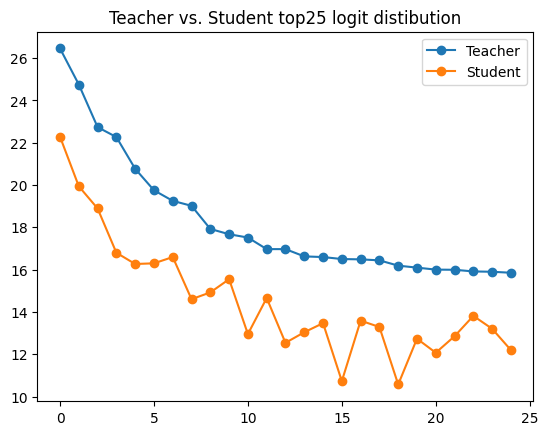

In [23]:
N = 25
topN_t, topN_idx = torch.topk(logits_t.cpu(), N)
topN_s = torch.gather(logits_s.detach().cpu(), dim=2, index=topN_idx)

plt.title(f"Teacher vs. Student top{N} logit distibution")
plt.plot(topN_t[0, 0, :], "-o", label="Teacher")
plt.plot(topN_s[0, 0, :], "-o", label="Student")
plt.legend()
plt.show()

In [1]:
# topN_t, topN_s